In [1]:
from stack import *

In [2]:
class stacking:
    def __init__(self, inst, ifield, m_min, m_max, srctype='g', savename=None, load_from_file=False):
        self.inst = inst
        self.ifield = ifield
        self.field = fieldnamedict[ifield]
        self.m_min = m_min
        self.m_max = m_max
        
        if savename is None:
            savename = './stack_data/stackdat_TM%d_%s_%d_%d'%(inst, self.field, m_min, m_max)
        self.savename = savename
        
        if load_from_file:
            stackdat = np.load(savename + '.npy' ,allow_pickle='TRUE').item()
        else:
            stackdat = self.stack_PS()
            self.stackdat = stackdat
            np.save(savename, stackdat)
            
#             self._get_jackknife_profile()
#             self._get_covariance()
#             self.stack_BG(Nbg=10)####
        
        self.stackdat = stackdat
        

    def stack_PS(self, srctype='g', dx=1200, unmask=True, verbose=True):

        inst = self.inst
        ifield = self.ifield
        m_min, m_max = self.m_min, self.m_max

        cbmap, psmap, strmask, strnum, mask_inst1, mask_inst2 = \
        load_processed_images(return_names=[(inst,ifield,'cbmap'), 
                                            (inst,ifield,'psmap'),
                                           (inst,ifield,'strmask'), 
                                           (inst,ifield,'strnum'),
                                           (1,ifield,'mask_inst'),
                                           (2,ifield,'mask_inst')])
        if inst==1:
            mask_inst = mask_inst1
        else:
            mask_inst = mask_inst2
            
        srcdat = ps_src_select(inst, ifield, m_min, m_max, [mask_inst1, mask_inst2])
        cliplim = self._stackihl_PS_cliplim()

        # init stackdat
        stackdat = {}
        stackdat['rbins'] = cliplim['rbins']
        stackdat['rbinedges'] = cliplim['rbinedges']
        stackdat['rsubbins'],stackdat['rsubbinedges'] =\
        self._radial_binning(cliplim['rbins'], cliplim['rbinedges'])
        stackdat['inst']= inst
        stackdat['ifield'] = ifield
        stackdat['field'] = fieldnamedict[ifield]
        stackdat['m_min'], stackdat['m_max'] = m_min, m_max
        stackdat['Nsrc'] = srcdat['N' + srctype]
        stackdat['Nsub'] = srcdat['Nsub']
        stackdat['sub'] = {}

        # start stacking
        Nbins = len(stackdat['rbins'])
        Nsubbins = len(stackdat['rsubbins'])
        radmapstamp =  make_radius_map(np.zeros((2*dx+1, 2*dx+1)), dx, dx) # subpix unit
        rbinedges = stackdat['rbinedges']/0.7 # subpix unit
        rsubbinedges = stackdat['rsubbinedges']/0.7 # subpix unit
        
        cbmapstack, psmapstack, maskstack = 0., 0., 0
        start_time = time.time()
        for isub in range(srcdat['Nsub']):
            stackdat['sub'][isub] = {}

            xls = srcdat['sub'][isub]['x' + srctype + '_arr']
            yls = srcdat['sub'][isub]['y' + srctype + '_arr']
            xss = np.round(xls * 10 + 4.5).astype(np.int32)
            yss = np.round(yls * 10 + 4.5).astype(np.int32)
            ms = srcdat['sub'][isub]['m' + srctype + '_arr']
            rs = get_mask_radius_th(ifield, ms) # arcsec

            print('stacking %s %d < m < %d, #%d subsample, %d sources, t = %.2f min'\
              %(fieldnamedict[ifield], m_min, m_max,isub, len(xls), (time.time()-start_time)/60))

            cbmapstacki, psmapstacki, maskstacki = 0., 0., 0
            for i,(xl,yl,xs,ys,r) in enumerate(zip(xls,yls,xss,yss,rs)):
                if len(xls)>20:
                    if verbose and i%(len(xls)//20)==0:
                        print('stacking %d / %d (%.1f %%), t = %.2f min'\
                              %(i, len(xls), i/len(xls)*100,  (time.time()-start_time)/60))
                cbmapi = cbmap*strmask*mask_inst
                psmapi = psmap*strmask*mask_inst
                maski = strmask*mask_inst
                radmap = make_radius_map(cbmap, xl,yl) # large pix units
                sp1 = np.where((radmap < r/7) & (strnum==1) & (mask_inst==1))
                cbmapi[sp1] = cbmap[sp1]
                psmapi[sp1] = psmap[sp1]
                unmaskpix = np.zeros_like(strmask)
                unmaskpix[sp1] = 1
                maski[sp1] = 1
                if len(sp1[0])>0 and unmask:
                    for ibin in range(Nbins):
                        if cliplim['CBmax'][ibin] == np.inf:
                            continue
                        spi = np.where((unmaskpix==1) & \
                                       (radmap*10>=rbinedges[ibin]) & \
                                       (radmap*10 < rbinedges[ibin+1]) & \
                                       (cbmap > cliplim['CBmax'][ibin]))
                        cbmapi[spi] = 0
                        psmapi[spi] = 0
                        maski[spi] = 0
                        spi = np.where((unmaskpix==1) & \
                                       (radmap*10>=rbinedges[ibin]) & \
                                       (radmap*10 < rbinedges[ibin+1]) & \
                                       (cbmap < cliplim['CBmin'][ibin]))
                        cbmapi[spi] = 0
                        psmapi[spi] = 0
                        maski[spi] = 0
                        spi = np.where((unmaskpix==1) & \
                                       (radmap*10>=rbinedges[ibin]) & \
                                       (radmap*10 < rbinedges[ibin+1]) & \
                                       (psmap > cliplim['PSmax'][ibin]))
                        cbmapi[spi] = 0
                        psmapi[spi] = 0
                        maski[spi] = 0
                        spi = np.where((unmaskpix==1) & \
                                       (radmap*10>=rbinedges[ibin]) & \
                                       (radmap*10 < rbinedges[ibin+1]) & \
                                       (psmap < cliplim['PSmin'][ibin]))
                        cbmapi[spi] = 0
                        psmapi[spi] = 0
                        maski[spi] = 0


                # unmask source
                mcb = cbmapi * maski
                mps = psmapi * maski

                mcb = self._image_finegrid(mcb)
                mps = self._image_finegrid(mps)
                k = self._image_finegrid(maski)

                # zero padding
                mcb = np.pad(mcb, ((dx,dx),(dx,dx)), 'constant')
                mps = np.pad(mps, ((dx,dx),(dx,dx)), 'constant')
                k = np.pad(k, ((dx,dx),(dx,dx)), 'constant')
                xs += dx
                ys += dx

                # cut stamp
                cbmapstamp = mcb[xs - dx: xs + dx + 1, ys - dx: ys + dx + 1]
                psmapstamp = mps[xs - dx: xs + dx + 1, ys - dx: ys + dx + 1]
                maskstamp = k[xs - dx: xs + dx + 1, ys - dx: ys + dx + 1]


                cbmapstacki += cbmapstamp
                psmapstacki += psmapstamp
                maskstacki += maskstamp
            
            ### end source for loop ###
            
            cbmapstack += cbmapstacki
            psmapstack += psmapstacki
            maskstack += maskstacki
                
            profcb_arr, profps_arr, hit_arr \
            = np.zeros(Nbins), np.zeros(Nbins), np.zeros(Nbins)
            for ibin in range(Nbins):
                spi = np.where((radmapstamp>=rbinedges[ibin]) &\
                               (radmapstamp<rbinedges[ibin+1]))
                profcb_arr[ibin] += np.sum(cbmapstacki[spi])
                profps_arr[ibin] += np.sum(psmapstacki[spi])
                hit_arr[ibin] += np.sum(maskstacki[spi])
            spbin = np.where(hit_arr!=0)[0]
            profcb_norm, profps_norm = np.zeros_like(profcb_arr), np.zeros_like(profps_arr)
            profcb_norm[spbin] = profcb_arr[spbin]/hit_arr[spbin]
            profps_norm[spbin] = profps_arr[spbin]/hit_arr[spbin]
            stackdat['sub'][isub]['profcb'] = profcb_norm
            stackdat['sub'][isub]['profps'] = profps_norm
            stackdat['sub'][isub]['profhit'] = hit_arr
        
            profcb_arr, profps_arr, hit_arr \
            = np.zeros(Nsubbins), np.zeros(Nsubbins), np.zeros(Nsubbins)
            for ibin in range(Nsubbins):
                spi = np.where((radmapstamp>=rsubbinedges[ibin]) &\
                               (radmapstamp<rsubbinedges[ibin+1]))
                profcb_arr[ibin] += np.sum(cbmapstacki[spi])
                profps_arr[ibin] += np.sum(psmapstacki[spi])
                hit_arr[ibin] += np.sum(maskstacki[spi])
            spbin = np.where(hit_arr!=0)[0]
            profcb_norm, profps_norm = np.zeros_like(profcb_arr), np.zeros_like(profps_arr)
            profcb_norm[spbin] = profcb_arr[spbin]/hit_arr[spbin]
            profps_norm[spbin] = profps_arr[spbin]/hit_arr[spbin]
            stackdat['sub'][isub]['profcbsub'] = profcb_norm
            stackdat['sub'][isub]['profpssub'] = profps_norm
            stackdat['sub'][isub]['profhitsub'] = hit_arr

            spi = np.where(radmapstamp>=100/0.7)
            stackdat['sub'][isub]['profcb100'] = np.sum(cbmapstacki[spi]) / np.sum(maskstacki[spi])
            stackdat['sub'][isub]['profps100'] = np.sum(psmapstacki[spi]) / np.sum(maskstacki[spi])
            stackdat['sub'][isub]['profhit100'] = np.sum(maskstacki[spi])

        ### end isub for loop ###
        
        spmap = np.where(maskstack!=0)
        cbmapstack_norm = np.zeros_like(cbmapstack)
        psmapstack_norm = np.zeros_like(psmapstack)
        cbmapstack_norm[spmap] = cbmapstack[spmap]/maskstack[spmap]
        psmapstack_norm[spmap] = psmapstack[spmap]/maskstack[spmap]
        stackdat['cbmapstack'] = cbmapstack_norm
        stackdat['psmapstack'] = psmapstack_norm
        stackdat['maskstack'] = maskstack

        profcb_arr, profps_arr, hit_arr \
        = np.zeros(Nbins), np.zeros(Nbins), np.zeros(Nbins)
        for ibin in range(Nbins):
            spi = np.where((radmapstamp>=rbinedges[ibin]) &\
                           (radmapstamp<rbinedges[ibin+1]))
            profcb_arr[ibin] += np.sum(cbmapstack[spi])
            profps_arr[ibin] += np.sum(psmapstack[spi])
            hit_arr[ibin] += np.sum(maskstack[spi])
        spbin = np.where(hit_arr!=0)[0]
        profcb_norm, profps_norm = np.zeros_like(profcb_arr), np.zeros_like(profps_arr)
        profcb_norm[spbin] = profcb_arr[spbin]/hit_arr[spbin]
        profps_norm[spbin] = profps_arr[spbin]/hit_arr[spbin]
        stackdat['profcb'] = profcb_norm
        stackdat['profps'] = profps_norm
        stackdat['profhit'] = hit_arr

        profcb_arr, profps_arr, hit_arr \
        = np.zeros(Nsubbins), np.zeros(Nsubbins), np.zeros(Nsubbins)
        for ibin in range(Nsubbins):
            spi = np.where((radmapstamp>=rsubbinedges[ibin]) &\
                           (radmapstamp<rsubbinedges[ibin+1]))
            profcb_arr[ibin] += np.sum(cbmapstack[spi])
            profps_arr[ibin] += np.sum(psmapstack[spi])
            hit_arr[ibin] += np.sum(maskstack[spi])
        spbin = np.where(hit_arr!=0)[0]
        profcb_norm, profps_norm = np.zeros_like(profcb_arr), np.zeros_like(profps_arr)
        profcb_norm[spbin] = profcb_arr[spbin]/hit_arr[spbin]
        profps_norm[spbin] = profps_arr[spbin]/hit_arr[spbin]
        stackdat['profcbsub'] = profcb_norm
        stackdat['profpssub'] = profps_norm
        stackdat['profhitsub'] = hit_arr

        spi = np.where(radmapstamp>=100/0.7)
        stackdat['profcb100'] = np.sum(cbmapstack[spi]) / np.sum(maskstack[spi])
        stackdat['profps100'] = np.sum(psmapstack[spi]) / np.sum(maskstack[spi])
        stackdat['profhit100'] = np.sum(maskstack[spi])

        return stackdat        
        
    def _stackihl_PS_cliplim(self, Nsrc=1000):
        inst = self.inst
        ifield = self.ifield
        m_min = self.m_min
        m_max = self.m_max
        cbmap, psmap, strnum, mask_inst1, mask_inst2 = \
        load_processed_images(return_names=[(inst,ifield,'cbmap'), 
                                            (inst,ifield,'psmap'),
                                           (inst,ifield,'strnum'),
                                           (1,ifield,'mask_inst'),
                                           (2,ifield,'mask_inst')])

        srcdat = ps_src_select(inst, ifield, m_min, m_max, [mask_inst1, mask_inst2], sample_type='all')

        x_arr = np.append(srcdat['xg_arr'],srcdat['xs_arr'])
        y_arr = np.append(srcdat['yg_arr'],srcdat['ys_arr'])
        m_arr = np.append(srcdat['mg_arr'],srcdat['ms_arr'])
        if inst==1:
            mask_inst = mask_inst1
        else:
            mask_inst = mask_inst2
        r_arr = get_mask_radius_th(ifield, m_arr) # arcsec

        if len(m_arr)>Nsrc:
            sp = np.arange(len(m_arr))
            np.random.shuffle(sp)
            sp = sp[:Nsrc]
        else:
            sp = np.arange(len(m_arr))
        x_arr, y_arr, m_arr, r_arr = x_arr[sp], y_arr[sp], m_arr[sp], r_arr[sp]

        nbins = 25
        dx = 1200
        profile = radial_prof(np.ones([2*dx+1,2*dx+1]), dx, dx)
        rbinedges, rbins = profile['rbinedges'], profile['rbins'] # subpix units

        cbdata, psdata = {}, {}
        for i in range(len(rbins)):
            cbdata[i] = np.array([])
            psdata[i] = np.array([])

        for isrc in range(len(x_arr)):
            radmap = make_radius_map(cbmap, x_arr[isrc], y_arr[isrc]) # large pix units
            sp1 = np.where((radmap < r_arr[isrc]/7) & (strnum==1) & (mask_inst==1))
            if len(sp1[0])==0:
                continue

            # unmasked radii and their CB, PS map values
            ri = radmap[sp1]*10 # sub pix units
            cbi, psi = cbmap[sp1], psmap[sp1]

            for ibin in range(len(rbins)):
                spi = np.where((ri>rbinedges[ibin]) & (ri<rbinedges[ibin+1]))[0]
                if len(spi)==0:
                    continue
                cbdata[ibin] = np.append(cbdata[ibin], cbi[spi])
                psdata[ibin] = np.append(psdata[ibin], psi[spi])

        cliplim = {'rbins': rbins*0.7, 'rbinedges': rbinedges*0.7,
                  'CBmax': np.full((nbins), np.inf),
                  'CBmin': np.full((nbins), -np.inf),
                  'PSmax': np.full((nbins), np.inf),
                  'PSmin': np.full((nbins), -np.inf),
                  }

        d = np.concatenate((cbdata[0],cbdata[1],cbdata[2],cbdata[3]))
        Q1, Q3 = np.percentile(d, 25), np.percentile(d, 75)
        IQR = Q3 - Q1
        cliplim['CBmin'][:4], cliplim['CBmax'][:4]= Q1-3*IQR, Q3+3*IQR

        d = np.concatenate((psdata[0],psdata[1],psdata[2],psdata[3]))
        Q1, Q3 = np.percentile(d, 25), np.percentile(d, 75)
        IQR = Q3 - Q1
        cliplim['PSmin'][:4], cliplim['PSmax'][:4]= Q1-3*IQR, Q3+3*IQR

        for ibin in np.arange(4,nbins,1):
            d = cbdata[ibin]
            if len(d)==0:
                continue
            Q1, Q3 = np.percentile(d, 25), np.percentile(d, 75)
            IQR = Q3 - Q1
            cliplim['CBmin'][ibin], cliplim['CBmax'][ibin]= Q1-3*IQR, Q3+3*IQR
            d = psdata[ibin]
            Q1, Q3 = np.percentile(d, 25), np.percentile(d, 75)
            IQR = Q3 - Q1
            cliplim['PSmin'][ibin], cliplim['PSmax'][ibin]= Q1-3*IQR, Q3+3*IQR

        return cliplim        

    def _image_finegrid(self, image, Nsub=10):
        w, h  = np.shape(image)
        image_new = np.zeros([w*Nsub, h*Nsub])
        for i in range(Nsub):
            for j in range(Nsub):
                image_new[i::Nsub, j::Nsub] = image
        return image_new
    
    def _radial_binning(self,rbins,rbinedges):
        rsubbinedges = np.concatenate((rbinedges[:1],rbinedges[6:20],rbinedges[-1:]))

        # calculate 
        rin = (2./3) * (rsubbinedges[1]**3 - rsubbinedges[0]**3)\
        / (rsubbinedges[1]**2 - rsubbinedges[0]**2)

        rout = (2./3) * (rsubbinedges[-1]**3 - rsubbinedges[-2]**3)\
        / (rsubbinedges[-1]**2 - rsubbinedges[-2]**2)

        rsubbins = np.concatenate(([rin],rbins[6:19],[rout]))

        return rsubbins, rsubbinedges
    
    def _get_jackknife_profile(self):
        self.stackdat['jack'] = {}
        for isub in range(self.stackdat['Nsub']):
            self.stackdat['jack'][isub] = {}
            profcb = self.stackdat['profcb']*self.stackdat['profhit'] - \
            self.stackdat['sub'][isub]['profcb']*self.stackdat['sub'][isub]['profhit']
            profps = self.stackdat['profps']*self.stackdat['profhit'] - \
            self.stackdat['sub'][isub]['profps']*self.stackdat['sub'][isub]['profhit']
            profhit = self.stackdat['profhit'] - self.stackdat['sub'][isub]['profhit']
            self.stackdat['jack'][isub]['profcb'] = profcb/profhit
            self.stackdat['jack'][isub]['profps'] = profps/profhit
            self.stackdat['jack'][isub]['profhit'] = profhit

            profcbsub = self.stackdat['profcbsub']*self.stackdat['profhitsub'] - \
            self.stackdat['sub'][isub]['profcbsub']*self.stackdat['sub'][isub]['profhitsub']
            profpssub = self.stackdat['profpssub']*self.stackdat['profhitsub'] - \
            self.stackdat['sub'][isub]['profpssub']*self.stackdat['sub'][isub]['profhitsub']
            profhitsub = self.stackdat['profhitsub'] - self.stackdat['sub'][isub]['profhitsub']
            self.stackdat['jack'][isub]['profcbsub'] = profcbsub/profhitsub
            self.stackdat['jack'][isub]['profpssub'] = profpssub/profhitsub
            self.stackdat['jack'][isub]['profhitsub'] = profhitsub

            profcb100 = self.stackdat['profcb100']*self.stackdat['profhit100'] - \
            self.stackdat['sub'][isub]['profcb100']*self.stackdat['sub'][isub]['profhit100']
            profps100 = self.stackdat['profps100']*self.stackdat['profhit100'] - \
            self.stackdat['sub'][isub]['profps100']*self.stackdat['sub'][isub]['profhit100']
            profhit100 = self.stackdat['profhit100'] - self.stackdat['sub'][isub]['profhit100']
            self.stackdat['jack'][isub]['profcb100'] = profcb100/profhit100
            self.stackdat['jack'][isub]['profps100'] = profps100/profhit100
            self.stackdat['jack'][isub]['profhit100'] = profhit100
            
        return
    
    def _normalize_cov(self, cov):
        cov_rho = np.zeros_like(cov)
        for i in range(cov_rho.shape[0]):
            for j in range(cov_rho.shape[0]):
                if cov[i,i]==0 or cov[j,j]==0:
                    cov_rho[i,j] = cov[i,j]
                else:
                    cov_rho[i,j] = cov[i,j] / np.sqrt(cov[i,i]*cov[j,j])
        return cov_rho

    def _get_covariance(self):
        self.stackdat['cov'] = {}
        Nsub = self.stackdat['Nsub']
        Nbins = len(self.stackdat['rbins'])
        Nsubbins = len(self.stackdat['rsubbins'])
        data_cb, data_ps = np.zeros([Nsub, Nbins]), np.zeros([Nsub, Nbins])
        data_cbsub, data_pssub = np.zeros([Nsub, Nbsubins]), np.zeros([Nsub, Nubbins])
        data_cb100, data_ps100 = np.zeros(Nsub), np.zeros(Nsub)

        for isub in range(Nsub):
            data_cb[isub,:] = self.stackdat['jack'][isub]['profcb']
            data_ps[isub,:] = self.stackdat['jack'][isub]['profcb']
            data_cbsub[isub,:] = self.stackdat['jack'][isub]['profcbsub']
            data_pssub[isub,:] = self.stackdat['jack'][isub]['profpssub']
            data_cb100[isub] = self.stackdat['jack'][isub]['profcb100']
            data_ps100[isub] = self.stackdat['jack'][isub]['profps100']

        covcb = np.zeros([Nbins, Nbins])
        covps = np.zeros([Nbins, Nbins])
        for i in range(Nbins):
            for j in range(Nbins):
                datai, dataj = data_cb[:,i], data_cb[:,j]
                covcb[i,j] = np.mean(datai*dataj) - np.mean(datai)*np.mean(dataj)
                datai, dataj = data_ps[:,i], data_ps[:,j]
                covps[i,j] = np.mean(datai*dataj) - np.mean(datai)*np.mean(dataj)
        self.stackdat['cov']['profcb'] = covcb * (Nsub-1)
        self.stackdat['cov']['profps'] = covps * (Nsub-1)
        self.stackdat['cov']['profcb_rho'] = self._normalize_cov(covcb)
        self.stackdat['cov']['profps_rho'] = self._normalize_cov(covps)

        covcb = np.zeros([Nsubbins, Nsubbins])
        covps = np.zeros([Nsubbins, Nsubbins])
        for i in range(Nsubbins):
            for j in range(Nsubbins):
                datai, dataj = data_cbsub[:,i], data_cbsub[:,j]
                covcb[i,j] = np.mean(datai*dataj) - np.mean(datai)*np.mean(dataj)
                datai, dataj = data_pssub[:,i], data_pssub[:,j]
                covps[i,j] = np.mean(datai*dataj) - np.mean(datai)*np.mean(dataj)
        self.stackdat['cov']['profcbsub'] = covcb * (Nsub-1)
        self.stackdat['cov']['profpssub'] = covps * (Nsub-1)
        self.stackdat['cov']['profcbsub_rho'] = self._normalize_cov(covcb)
        self.stackdat['cov']['profpssub_rho'] = self._normalize_cov(covps)

        covcb = np.mean(data_cb100**2) - np.mean(data_cb100)**2
        covps = np.mean(data_ps100**2) - np.mean(data_ps100)**2
        self.stackdat['cov']['profcb100'] = covcb * (Nsub-1)
        self.stackdat['cov']['profps100'] = covps * (Nsub-1)

        return
    
    def stack_BG(self, srctype='g', dx=120, verbose=True, Nbg=50):

        inst = self.inst
        ifield = self.ifield
        m_min, m_max = self.m_min, self.m_max

        cbmap, psmap, strmask, mask_inst = \
        load_processed_images(return_names=[(inst,ifield,'cbmap'), 
                                            (inst,ifield,'psmap'),
                                           (inst,ifield,'strmask'), 
                                           (inst,ifield,'mask_inst')])
        Nsrc = self.stackdat['Nsrc']
        self.stackdat['bg'] = {}

        # start stacking
        Nbins = len(self.stackdat['rbins'])
        Nsubbins = len(self.stackdat['rsubbins'])
        radmapstamp =  make_radius_map(np.zeros((2*dx+1, 2*dx+1)), dx, dx) # subpix unit
        rbins = self.stackdat['rbins']/7 # pix unit
        rsubbins = self.stackdat['rsubbins']/7 # pix unit        
        rbinedges = self.stackdat['rbinedges']/7 # pix unit
        rsubbinedges = self.stackdat['rsubbinedges']/7 # pix unit

        cbmapi = cbmap*strmask*mask_inst
        psmapi = psmap*strmask*mask_inst
        maski = strmask*mask_inst

        start_time = time.time()
        for isub in range(Nbg):
            stackdat['BG'][isub] = {}
            print('stacking %s %d < m < %d, #%d BG, %d sources, t = %.2f min'\
              %(fieldnamedict[ifield], m_min, m_max,isub, Nsrc, (time.time()-start_time)/60))

            cbmapstacki, psmapstacki, maskstacki = 0., 0., 0
            for i in range(Nsrc):
                xi, yi = np.random.randint(0,1024,2)
                radmap = make_radius_map(cbmap, xi, yi) # large pix units

                # zero padding
                mcb = np.pad(cbmapi, ((dx,dx),(dx,dx)), 'constant')
                mps = np.pad(psmapi, ((dx,dx),(dx,dx)), 'constant')
                k = np.pad(maski, ((dx,dx),(dx,dx)), 'constant')
                xi += dx
                yi += dx

                # cut stamp
                cbmapstamp = mcb[xi - dx: xi + dx + 1, yi - dx: yi + dx + 1]
                psmapstamp = mps[xi - dx: xi + dx + 1, yi - dx: yi + dx + 1]
                maskstamp = k[xi - dx: xi + dx + 1, yi - dx: yi + dx + 1]

                cbmapstacki += cbmapstamp
                psmapstacki += psmapstamp
                maskstacki += maskstamp

            ### end source for loop ###
            cbmapstack += cbmapstacki
            psmapstack += psmapstacki
            maskstack += maskstacki

            profcb_arr, profps_arr, hit_arr \
            = np.zeros(Nbins), np.zeros(Nbins), np.zeros(Nbins)
            for ibin in range(Nbins):
                spi = np.where((radmapstamp>=rbinedges[ibin]) &\
                               (radmapstamp<rbinedges[ibin+1]))
                profcb_arr[ibin] += np.sum(cbmapstacki[spi])
                profps_arr[ibin] += np.sum(psmapstacki[spi])
                hit_arr[ibin] += np.sum(maskstacki[spi])
            spbin = np.where(hit_arr!=0)[0]
            profcb_norm, profps_norm = np.zeros_like(profcb_arr), np.zeros_like(profps_arr)
            profcb_norm[spbin] = profcb_arr[spbin]/hit_arr[spbin]
            profps_norm[spbin] = profps_arr[spbin]/hit_arr[spbin]
            profcb_norm = np.interp(rbins, rbins[spbin], profcb_norm[spbin])
            profps_norm = np.interp(rbins, rbins[spbin], profcb_norm[spbin])
            self.stackdat['BG'][isub]['profcb'] = profcb_norm
            self.stackdat['BG'][isub]['profps'] = profps_norm
            self.stackdat['BG'][isub]['profhit'] = hit_arr

            profcb_arr, profps_arr, hit_arr \
            = np.zeros(Nsubbins), np.zeros(Nsubbins), np.zeros(Nsubbins)
            for ibin in range(Nsubbins):
                spi = np.where((radmapstamp>=rsubbinedges[ibin]) &\
                               (radmapstamp<rsubbinedges[ibin+1]))
                profcb_arr[ibin] += np.sum(cbmapstacki[spi])
                profps_arr[ibin] += np.sum(psmapstacki[spi])
                hit_arr[ibin] += np.sum(maskstacki[spi])
            spbin = np.where(hit_arr!=0)[0]
            profcb_norm, profps_norm = np.zeros_like(profcb_arr), np.zeros_like(profps_arr)
            profcb_norm[spbin] = profcb_arr[spbin]/hit_arr[spbin]
            profps_norm[spbin] = profps_arr[spbin]/hit_arr[spbin]
            profcb_norm = np.interp(rsubbins, rsubbins[spbin], profcb_norm[spbin])
            profps_norm = np.interp(rsubbins, rsubbins[spbin], profcb_norm[spbin])
            self.stackdat['BG'][isub]['profcbsub'] = profcb_norm
            self.stackdat['BG'][isub]['profpssub'] = profps_norm
            self.stackdat['BG'][isub]['profhitsub'] = hit_arr

            spi = np.where(radmapstamp>=100/7)
            self.stackdat['BG'][isub]['profcb100'] = np.sum(cbmapstacki[spi]) / np.sum(maskstacki[spi])
            self.stackdat['BG'][isub]['profps100'] = np.sum(psmapstacki[spi]) / np.sum(maskstacki[spi])
            self.stackdat['BG'][isub]['profhit100'] = np.sum(maskstacki[spi])

        ### end isub for loop ###

        spmap = np.where(maskstack!=0)
        cbmapstack_norm = np.zeros_like(cbmapstack)
        psmapstack_norm = np.zeros_like(psmapstack)
        cbmapstack_norm[spmap] = cbmapstack[spmap]/maskstack[spmap]
        psmapstack_norm[spmap] = psmapstack[spmap]/maskstack[spmap]
        self.stackdat['cbmapstackBG'] = cbmapstack_norm
        self.stackdat['psmapstackBG'] = psmapstack_norm
        self.stackdat['maskstackBG'] = maskstack

        return stackdat

In [3]:
inst = 1
ifield = 4
m_min, m_max = 16,17
stack = stacking(inst, ifield, m_min, m_max, load_from_file=False)

stacking elat10 16 < m < 17, #0 subsample, 2 sources, t = 0.00 min
stacking elat10 16 < m < 17, #1 subsample, 2 sources, t = 1.06 min
stacking elat10 16 < m < 17, #2 subsample, 2 sources, t = 2.01 min
stacking elat10 16 < m < 17, #3 subsample, 2 sources, t = 2.97 min
stacking elat10 16 < m < 17, #4 subsample, 2 sources, t = 3.96 min
stacking elat10 16 < m < 17, #5 subsample, 2 sources, t = 5.26 min
stacking elat10 16 < m < 17, #6 subsample, 2 sources, t = 6.36 min
stacking elat10 16 < m < 17, #7 subsample, 2 sources, t = 7.32 min
stacking elat10 16 < m < 17, #8 subsample, 2 sources, t = 8.28 min
stacking elat10 16 < m < 17, #9 subsample, 2 sources, t = 9.25 min
stacking elat10 16 < m < 17, #10 subsample, 2 sources, t = 10.23 min
stacking elat10 16 < m < 17, #11 subsample, 2 sources, t = 11.38 min
stacking elat10 16 < m < 17, #12 subsample, 2 sources, t = 12.75 min
stacking elat10 16 < m < 17, #13 subsample, 2 sources, t = 14.09 min
stacking elat10 16 < m < 17, #14 subsample, 2 sources,

AttributeError: 'stacking' object has no attribute 'stackdat'

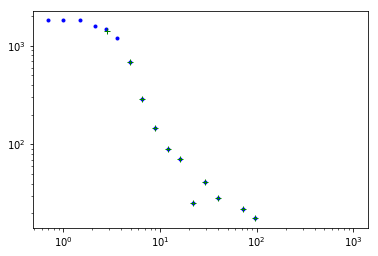

In [100]:
for i in [0]:#range(stack.stackdat['Nsub']):
    plt.loglog(stack.stackdat['rbins'],stack.stackdat['sub'][i]['profcb'],'b.')
    plt.loglog(stack.stackdat['rsubbins'],stack.stackdat['sub'][i]['profcbsub'],'g+')
# plt.loglog(stack.stackdat['rbins'],stack.stackdat['profcb'],'ko')
# plt.loglog(stack.stackdat['rsubbins'],stack.stackdat['profcbsub'],'g+')

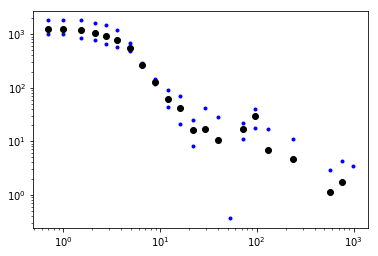

In [91]:
for i in [0,1]:#range(stack.stackdat['Nsub']):
    plt.loglog(stack.stackdat['rbins'],stack.stackdat['sub'][i]['profcb'],'b.')
plt.loglog(stack.stackdat['rbins'],stack.stackdat['profcb'],'ko')